In [1]:
from google.colab import drive
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations_with_replacement

In [2]:
drive.mount('/content/drive')
image_tags = pd.read_csv('/content/drive/Shared drives/TCC/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
image_tags = image_tags.set_index('image_name')
image_tags.head()

,tags
image_name,
train_0,haze primary
train_1,agriculture clear primary water
train_2,clear primary
train_3,clear primary
train_4,agriculture clear habitation primary road


In [4]:
image_tags['tags'] = image_tags['tags'].map(lambda x: x.replace('primary', ''))
image_tags['tags'] = image_tags['tags'].map(lambda x: x.replace('clear', ''))
image_tags['tags'] = image_tags['tags'].map(lambda x: x.replace('partly_cloudy', ''))
image_tags['tags'] = image_tags['tags'].map(lambda x: x.replace('cloudy', ''))
image_tags['tags'] = image_tags['tags'].map(lambda x: x.replace('haze', ''))
image_tags['tags'] = image_tags['tags'].map(lambda x: x.replace('   ', ' '))
image_tags['tags'] = image_tags['tags'].map(lambda x: x.replace('  ', ' '))
image_tags['tags'] = image_tags['tags'].map(lambda x: x.strip())
image_tags['tags'] = image_tags['tags'].map(lambda x: x.strip(''))

image_tags = image_tags[image_tags.tags != '']


In [5]:
G = nx.MultiGraph()

for image_tag in image_tags['tags'].values:
  image_tag_list = [x.strip() for x in image_tag.split(' ')]

  k = 0 
  
  while k < len(image_tag_list)-1:
    actual_node = image_tag_list[k]

    for i in range (1, len(image_tag_list)-k):
      G.add_edge(actual_node, image_tag_list[k+i])

    k = k+1

In [6]:
df = pd.DataFrame(nx.to_numpy_matrix(G), index=G.nodes, columns = G.nodes())
df

,agriculture,water,habitation,road,cultivation,slash_burn,bare_ground,artisinal_mine,blooming,selective_logging,blow_down,conventional_mine
agriculture,0.0,2712.0,2737.0,6034.0,3447.0,119.0,225.0,38.0,32.0,65.0,23.0,24.0
water,2712.0,0.0,915.0,2125.0,887.0,24.0,206.0,299.0,16.0,49.0,3.0,26.0
habitation,2737.0,915.0,0.0,2786.0,925.0,41.0,163.0,29.0,4.0,13.0,3.0,36.0
road,6034.0,2125.0,2786.0,0.0,1337.0,36.0,323.0,110.0,10.0,151.0,2.0,59.0
cultivation,3447.0,887.0,925.0,1337.0,70.0,130.0,89.0,18.0,35.0,58.0,8.0,4.0
slash_burn,119.0,24.0,41.0,36.0,130.0,0.0,10.0,0.0,2.0,2.0,2.0,0.0
bare_ground,225.0,206.0,163.0,323.0,89.0,10.0,0.0,40.0,3.0,13.0,4.0,10.0
artisinal_mine,38.0,299.0,29.0,110.0,18.0,0.0,40.0,0.0,0.0,6.0,0.0,4.0
blooming,32.0,16.0,4.0,10.0,35.0,2.0,3.0,0.0,0.0,7.0,1.0,0.0
selective_logging,65.0,49.0,13.0,151.0,58.0,2.0,13.0,6.0,7.0,0.0,1.0,0.0


In [32]:
edge_list = nx.to_pandas_edgelist(G).reset_index().groupby(['source', 'target']).count().rename(columns={'index': 'weight'}).reset_index()
nodes_list = nx.to_pandas_edgelist(G).groupby(['source']).count()
nodes_list_2 = nx.to_pandas_edgelist(G).groupby(['target']).count()
nodes_list = nodes_list.join(nodes_list_2).fillna(0) 
nodes_list['sum'] = nodes_list['target'] + nodes_list['source']
nodes_list = nodes_list['sum'].values.tolist()

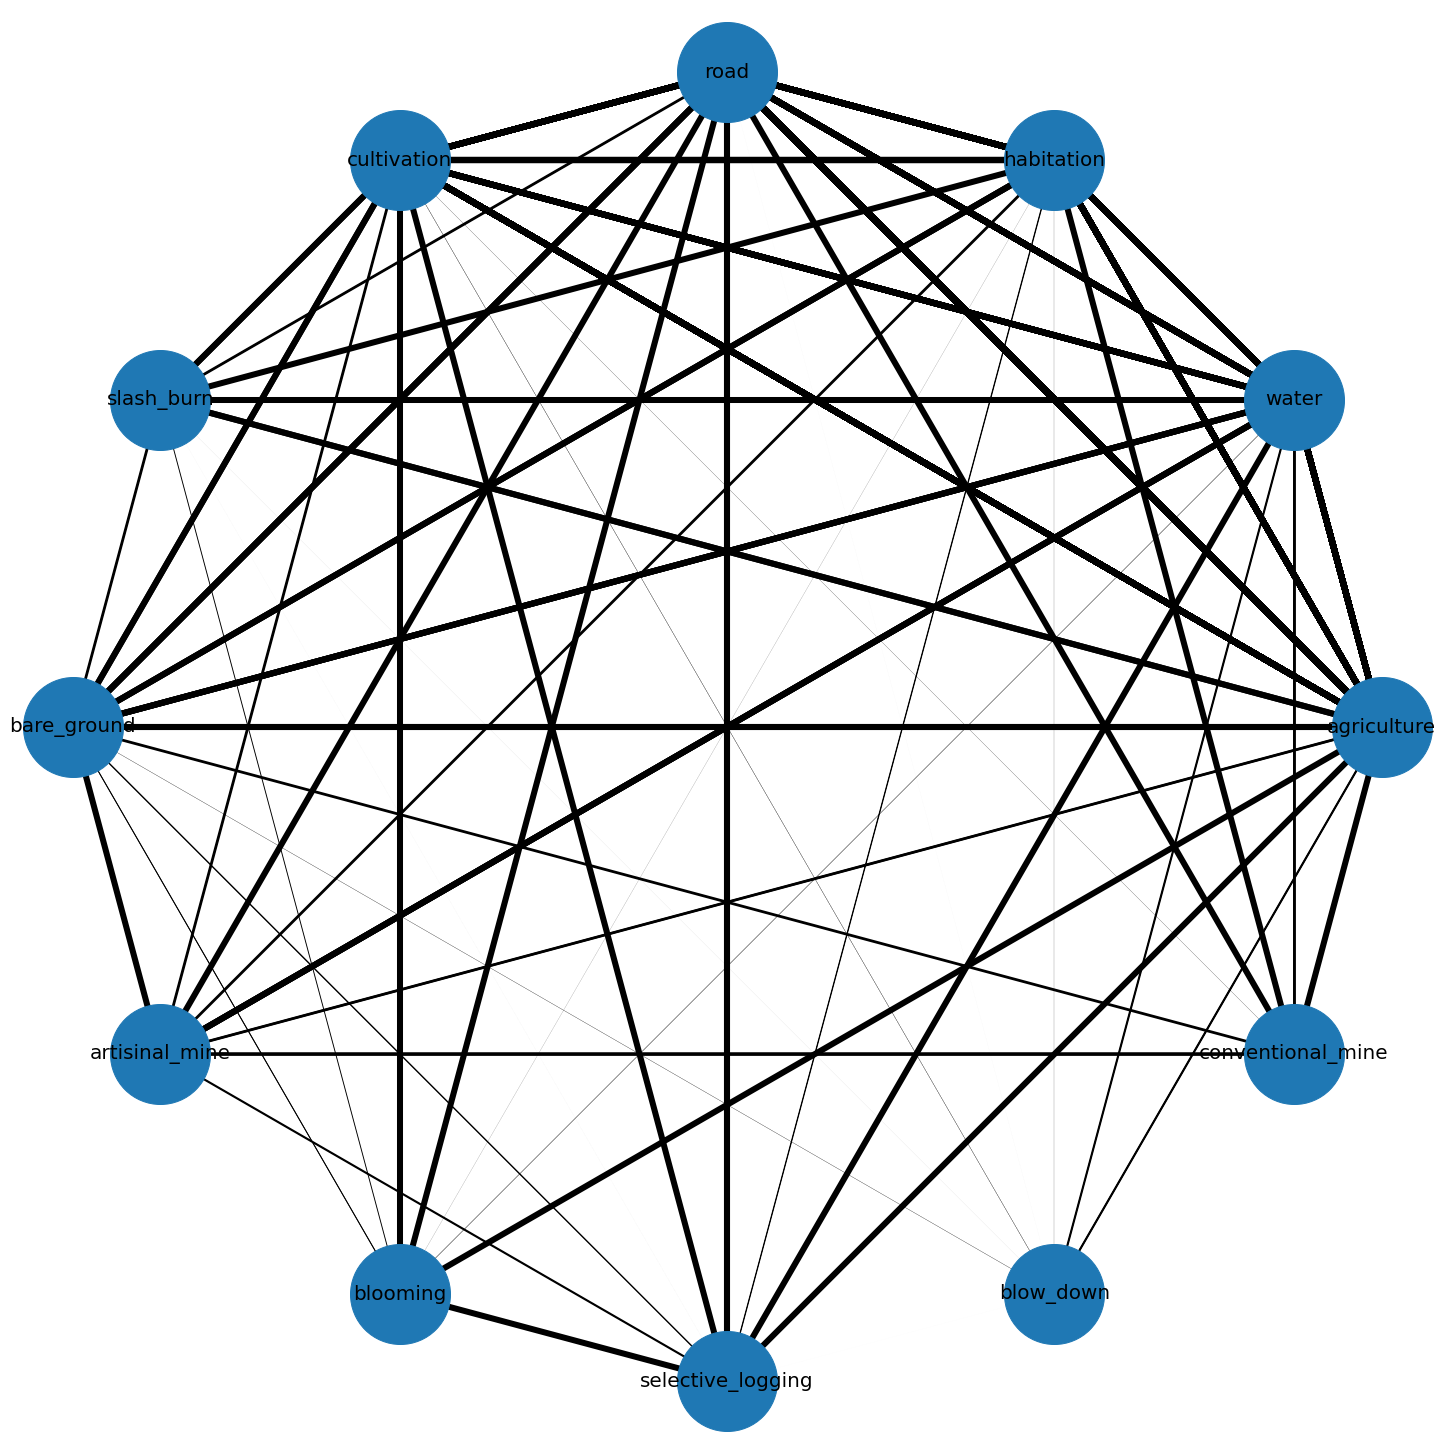

In [35]:
import matplotlib as mpl
nx.draw_circular(G, with_labels=True, node_size=10000, font_size=20, width=edge_list.weight/1000)
mpl.rcParams['figure.figsize'] = [20, 20]

In [12]:
df_total = pd.DataFrame(df.sum(axis=0), columns=['total'])
df_total = df_total.sort_values(by='total').reset_index()
df_total = df_total.loc[:5, 'index']
six_min_tags = df_total.values.tolist()

In [13]:

def top_labels(tag):
  top_5 = df.loc[tag].sort_values(ascending = False)[:5].index.tolist()

  df_final = pd.DataFrame(columns = ['Combinação', 'Result'])

  permsList = list(combinations_with_replacement(top_5, 5))

  for combination in permsList:
    
    df_tags = pd.DataFrame(columns = ['tag', 'image_tags'])
    for image_tag in image_tags['tags'].values:
      flag = True
      for label in combination:
        if label not in image_tag:
          flag = False

      if flag:
        line = {'tag':[tag], 'image_tags':[image_tag]}
        df_tags = df_tags.append(pd.DataFrame.from_dict(line), ignore_index = True)

    tag_count = 0
    for image_tag in df_tags.image_tags:
      if tag in image_tag:
        tag_count = tag_count+1


    if len(df_tags.image_tags)>0:
      final_line = {'Combinação': [str(combination)], 'Result': tag_count/len(df_tags.image_tags)}
      df_final = df_final.append(pd.DataFrame.from_dict(final_line), ignore_index = True)

  df_final = df_final.sort_values(by='Result', ascending = False)
  return df_final

In [ ]:
conventional_mine = top_labels('conventional_mine')
conventional_mine.to_csv('/content/drive/Shared drives/TCC/conventional_mine.csv')

In [ ]:
blow_down = top_labels('blow_down')
blow_down.to_csv('/content/drive/Shared drives/TCC/blow_down.csv')

In [ ]:
blooming = top_labels('blooming')
blooming.to_csv('/content/drive/Shared drives/TCC/blooming.csv')

In [ ]:
selective_logging = top_labels('selective_logging')
selective_logging.to_csv('/content/drive/Shared drives/TCC/selective_logging.csv')

In [ ]:
slash_burn = top_labels('slash_burn')
slash_burn.to_csv('/content/drive/Shared drives/TCC/slash_burn.csv')

In [ ]:
artisinal_mine = top_labels('artisinal_mine')
artisinal_mine.to_csv('/content/drive/Shared drives/TCC/artisinal_mine.csv')